# Homework 6 Solutions

Computational Physics Fall 2025 

# Problem 1: Newtron Scattering

## Part A

If we have a set of $S$ points we can write a polynomial of degree $|S|-1$ for each of the points such that it has a root at all points except one through the map $l: S \to \mathbb{R}[x]$ defined by 
$$
s\mapsto l_s(x) \coloneqq \prod_{p \in S\setminus \{s\}} \frac{x-p}{s-p},
$$
therefore given a set of data $D = \{(x_i,y_i) \mid 1\leq i \leq N \}$ we can write a polynomial that interpolates them by
$$
f(x) = \sum_{(x_i,y_i) \in D} y_i l_{x_i}(x).
$$
Let's implement this.

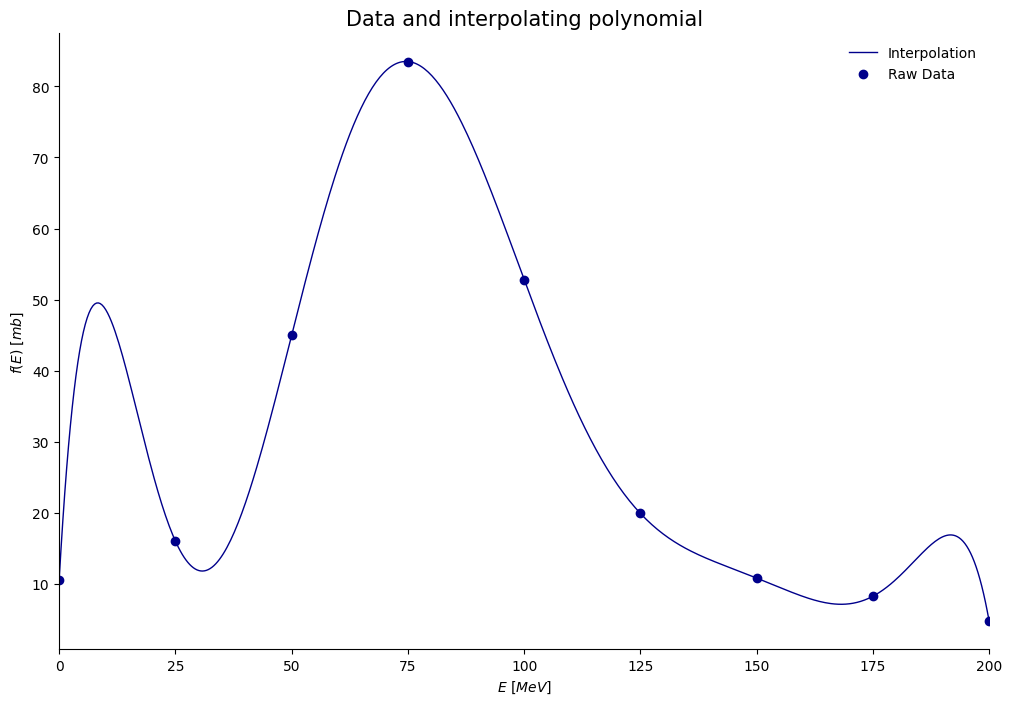

In [1]:
from math import prod               # Product of a list
import matplotlib.pyplot as plt     # Plotting goodness
from numpy import linspace          # heghe

# "Load" the data :sob:
D = {
      0.: 10.6,
     25.: 16.0,
     50.: 45.0,
     75.: 83.5,
    100.: 52.8,
    125.: 19.9,
    150.: 10.8,
    175.: 8.25,
    200.: 4.70,
}

# With this out of the way, let's define the interpolating function. 
# Returns a function that we can evaluate as a lagrange interpolant
def get_lagrange_interpolant(D):
    # return the function that interpolates everything
    return lambda x: sum([D[s]*prod([(x-p)/(s-p) for p in D if p != s]) for s in D])

# Run this
f = get_lagrange_interpolant(D)

# PLOTTING ---------------------------------------------------
fig = plt.figure(figsize=(12,8))
ax  = fig.add_subplot(111)

# Add the plot elements
E = linspace(min(D),max(D),500)
ax.plot(E, [f(e) for e in E], color='darkblue', lw=1, label="Interpolation")
ax.scatter(list(D),list(D.values()), color='darkblue', marker="o", lw=1, label="Raw Data")


# Some prettification steps
ax.set_title("Data and interpolating polynomial",fontsize=15)
ax.legend(frameon=False)
ax.set_xlabel(r'$E \ [MeV]$')
ax.set_ylabel(r'$f(E)\ [mb]$')
ax.set_xlim(min(D),max(D))
ax.spines[['top', 'right']].set_visible(False)

Roughly looking at this the peak is at $f(74) = 84$ and the fwhm is $\Gamma = 50$.

To do this locally, we will split our Dictionary into pieces of 3 data points each. and then repeat the process.

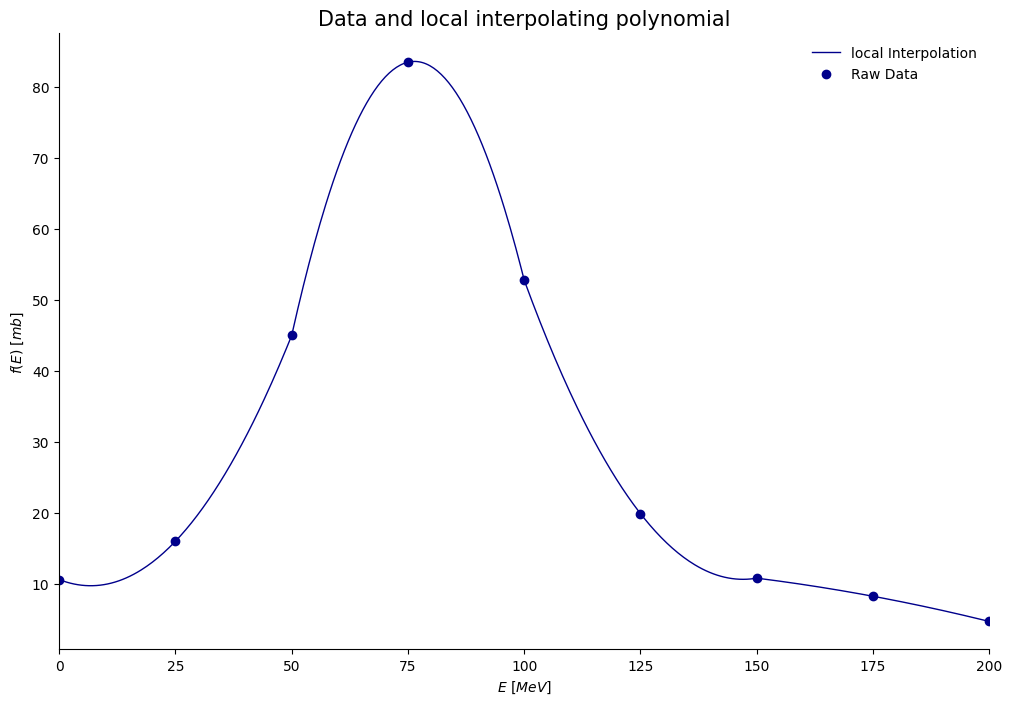

In [2]:
from itertools import islice
from bisect import bisect_left

# First split the data into 4 part, each with three elements
D_split = {i: dict(islice(iter(D.items()),len(D)//4*i, len(D)//4*(i+1) + 1)) for i in range(4)}

# Interpolate
F = {i: get_lagrange_interpolant(D_split[i]) for i in D_split}
f = lambda x: F[max((bisect_left(list(D.keys()),x)-1)//2, 0)](x)

# PLOTTING ---------------------------------------------------
fig = plt.figure(figsize=(12,8))
ax  = fig.add_subplot(111)

# Add the plot elements
E = linspace(min(D),max(D),500)
ax.plot(E, [f(e) for e in E], color='darkblue', lw=1, label="local Interpolation")
ax.scatter(list(D),list(D.values()), color='darkblue', marker="o", lw=1, label="Raw Data")


# Some prettification steps
ax.set_title("Data and local interpolating polynomial",fontsize=15)
ax.legend(frameon=False)
ax.set_xlabel(r'$E\ [MeV]$')
ax.set_ylabel(r'$f(E)\ [mb]$')
ax.set_xlim(min(D),max(D))
ax.spines[['top', 'right']].set_visible(False)

In here we get that the maximum is closer it is roughly at $E = 77\ MeV$ and $\Gamma = 55$.

# Problem 2: Inverse Power Distribution

To normalize our function we need to integrate it. Specifically we have that 
$$
1 = \int_{\mathbb{R}^+} \frac{A}{(1+x)^n} dx = \left[ -\frac{A}{(n-1)(1+x)^{n-1}} \right]_{0}^\infty = \frac{A}{n-1} \implies A = n-1.
$$

Now we want a transformation that will unsquish the probability distribution $f$. We want to to find a transformation $r: \mathbb{R}^+ \to I$ such that 
$$
r^\ast dx = \frac{dr}{dx} dx = f dx \implies \frac{dr}{dx} = f \implies r(x) = 1 - (1+x)^{1-n}.
$$
Now we just need to invert this to find that 
$$
\boxed{x(r) = (1-r)^{\frac{1}{1-n}} -1.}
$$

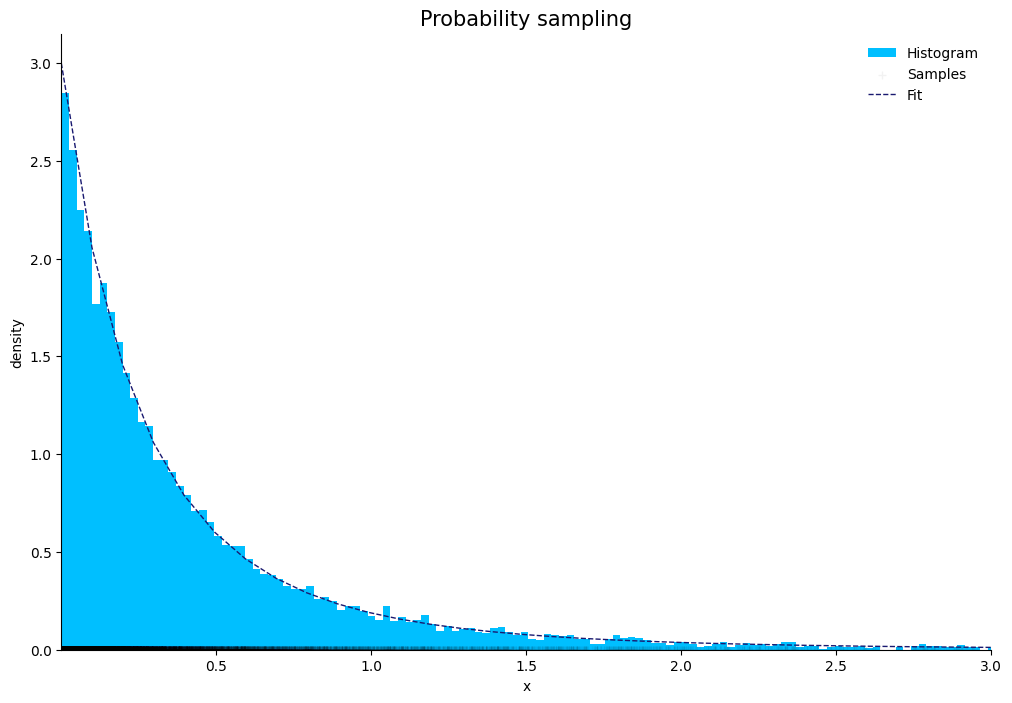

In [3]:
# To actually draw from this distribution we can simply take
from numpy.random import uniform

# Get the random numbers
N = 10000
n = 4
r = uniform(size = N)
x = (1-r)**(1/(1-n)) - 1
X = linspace(min(x),max(x),500)
f = (n-1)/(1+X)**n

# PLOTTING ---------------------------------------------------
fig = plt.figure(figsize=(12,8))
ax  = fig.add_subplot(111)

# Add the plot elements
ax.hist(x,bins=2000, density=True, color="deepskyblue", label='Histogram')

ax.scatter(x,[0]*len(x), color='k', marker="+", lw=1, label="Samples",alpha=0.05)
ax.plot(X,f, color = 'midnightblue', lw=1, ls='--', label="Fit")


# Some prettification steps
ax.set_title("Probability sampling",fontsize=15)
ax.legend(frameon=False)
ax.set_xlabel(r'x')
ax.set_ylabel(r'density')
ax.set_xlim(min(X),3)
ax.spines[['top', 'right']].set_visible(False)

# Problem 3: Radioactive Decay Chain

The probability that something with a halflife $\tau$ will survive for a time $t$ is
$$
P(t) = e^{-\frac{t}{\tau}},
$$
Therefore each second we can count the probability that the particle survived using $P(1s)$ and the probability that it didn't using $1-P(1s)$. We will do all of our measurements in seconds.

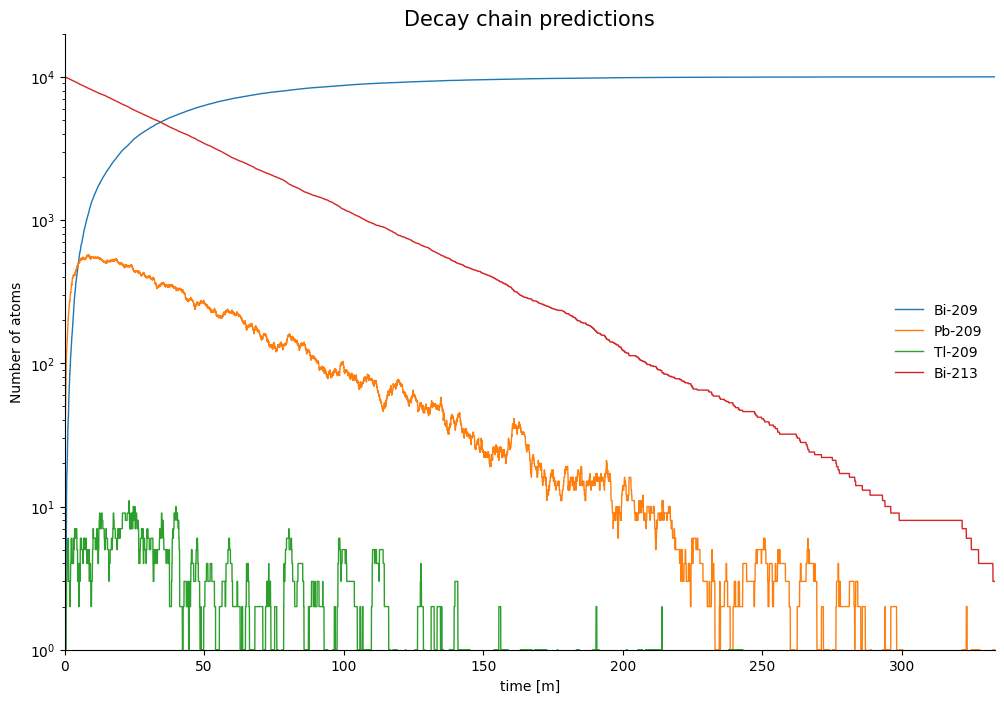

In [4]:
from numpy import exp, logical_and

# Let's define some constants
m = 60. # seconds
t = {
    'Pb-209': 3.3*m,
    'Tl-209': 2.2*m,
    'Bi-213': 46.*m,
}

# Let's also store the decay pathways
pathways = {
    'Bi-209': {},
    'Pb-209': {'Bi-209':1},
    'Tl-209': {'Pb-209':1},
    'Bi-213': {'Pb-209':0.9791, 'Tl-209':0.0209},
}

# We can keep track of the number of atoms of each species using a dictionary
N = {
    'Bi-209': [0],
    'Pb-209': [0],
    'Tl-209': [0],
    'Bi-213': [10000],
}

# We define a coin flip function that tells us if a coin flip 
# has succeeded with a certain probability
def flip(P:float,N:int=1):
    return P>uniform(size=N)

# One more function to sample a pathway and return 
# How many decays we had for each pathway
def flip_pathway(pathway, N:int=10):
    # Don't sample if you don't need to
    if len(pathway) == 1:
        return {key: N for key in pathway}

    # Now sample
    probs   = list(pathway.values())    
    sample  = uniform(size=N)
    # print(sample,probs)
    # [ print(sum(probs[:i]),sum(probs[:i]) <= sample,sample < sum(probs[:i])) for i,key in enumerate(pathway)]
    return {key: sum(logical_and(sum(probs[:i]) <= sample,sample < sum(probs[:i+1]))) for i,key in enumerate(pathway)}

# Now we will write a function that will update the populations for each step
def step(N:dict, delta:float = 1):

    # For each element in reverse order
    for element in pathways:
        # Append a new element to its array
        N[element].append(N[element][-1])

        # If the element can't decay, skip it
        if pathways[element] == {} or N[element][-1] == 0: 
            continue

        # Find how many decay
        N_decay = sum(flip(1-exp(-delta/t[element]), N[element][-1]))

        # Find how many decay on each pathway
        N_path = flip_pathway(pathways[element],N_decay)

        # Update the numbers accordingly
        N[element][-1] -= N_decay
        for species in N_path:
            N[species][-1] += N_path[species]
    
    return N


# Finally we wrap everything into a simulate function
def simulate(time:float = 10000, delta:float = 1, N:dict=N):
    for i in range(int(time/delta)):
        N = step(N,delta)
    
    return N

time = 20000
results = simulate(time = time)
T = linspace(0, time/m, time+1)

# PLOTTING ---------------------------------------------------
fig = plt.figure(figsize=(12,8))
ax  = fig.add_subplot(111)

# Add the plot elements
for element in results:
    ax.plot(T,results[element], lw=1, label=element)


# Some prettification steps
ax.set_title("Decay chain predictions",fontsize=15)
ax.legend(frameon=False)
ax.set_xlabel(r'time [m]')
ax.set_ylabel(r'Number of atoms')
ax.set_yscale("log")
ax.set_xlim(min(T),max(T))
ax.set_ylim(1,2e4)
ax.spines[['top', 'right']].set_visible(False)


# Problem 4 : Radiactive Decay Again

We are effectively redoing problem 2. We want to create a new variable $u(t) = P(t)$ and solve $t(u)$ we do this like so
$$
u(t) = e^{-t/\tau} \implies t = -\tau \log(u).
$$
Therefore we can now sample a uniform $u$ and obtain a sample for $t$. 

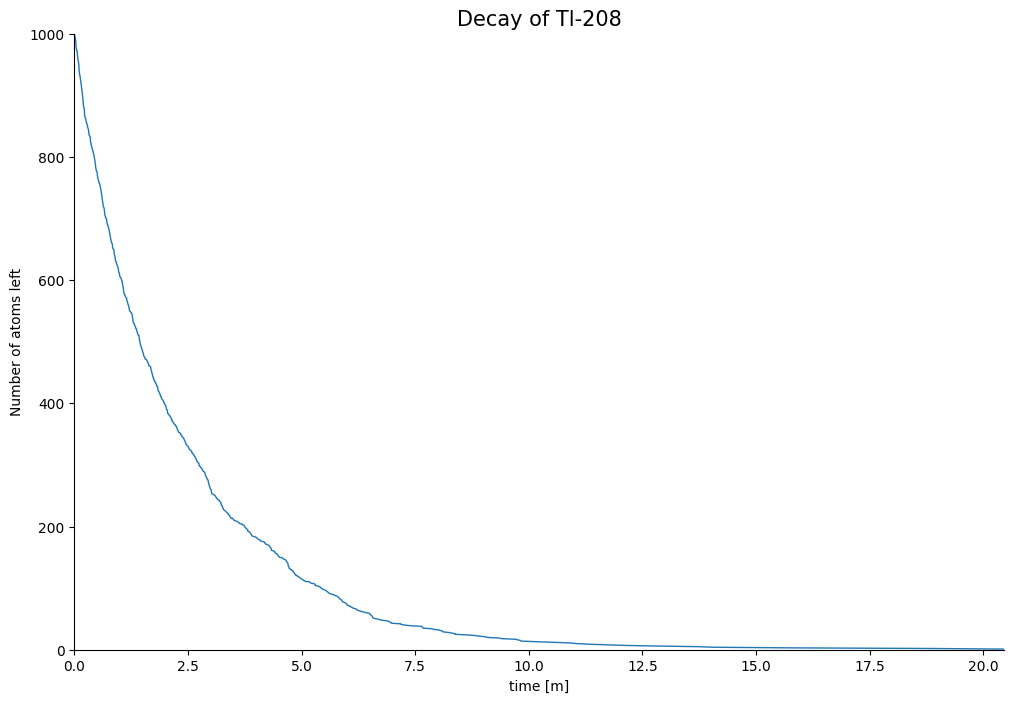

In [5]:
from numpy import log, sort, arange

# Sample a uniform distribution
n = 1000
u = uniform(size = n)

# Convert to a bunch of decay times
T = sort(-t['Tl-209']*log(u))

# Now let's plot the number of atoms that have decayed
N = n - arange(len(T))

# PLOTTING ---------------------------------------------------
fig = plt.figure(figsize=(12,8))
ax  = fig.add_subplot(111)

# Add the plot elements
ax.plot(T/m,N, lw=1)


# Some prettification steps
ax.set_title("Decay of Tl-208",fontsize=15)
ax.set_xlabel(r'time [m]')
ax.set_ylabel(r'Number of atoms left')
ax.set_xlim(0,max(T/m))
ax.set_ylim(0,n)
ax.spines[['top', 'right']].set_visible(False)